<h1 style="font-family: 'Roboto', sans-serif; font-size: 32px; color: #008080;"> Agricultural Pest Classification using Deep Learning: ResNet and InceptionV3

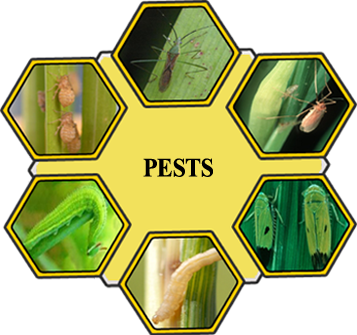
    
<h2 style="font-family: 'Roboto', sans-serif; font-size: 24px; color: #000000;">Introduction:</h2>

<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;">Welcome to this Kaggle notebook, where we explore the fascinating world of agricultural pest classification using the power of deep learning. In this project, we aim to assist farmers in effectively identifying and managing common agricultural pests using two powerful pre-trained deep learning models, ResNet and InceptionV3.

<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;">Agricultural pests pose significant threats to crop yield and quality, making their timely detection and appropriate management critical for sustainable agriculture. Traditional pest identification methods can be time-consuming and error-prone. Leveraging the capabilities of deep learning, we present an innovative solution that automates the classification process, providing farmers with a reliable and efficient tool for pest identification. Throughout this notebook, we will embark on a journey of data preprocessing, augmentation, and fine-tuning of ResNet and InceptionV3 models. We will explore transfer learning techniques to harness the knowledge of these state-of-the-art models while adapting them to our specific agricultural pest classification task. Furthermore, we will conduct thorough model evaluation, analyzing accuracy, loss, and generating insightful visualizations like confusion matrices to assess the performance of our models on different pest classes.

<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;">By the end of this notebook, we hope to showcase the effectiveness of deep learning models in agricultural pest classification and inspire the adoption of advanced technologies for precision agriculture. So, let's dive in and witness the power of ResNet and InceptionV3 in identifying and mitigating the challenges posed by agricultural pests. 

#    Happy learning!

# Import required libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random
import warnings
warnings.filterwarnings("ignore")
# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='darkgrid')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;">Setting the seed ensures that the random processes involved in training and testing models are initialized in the same state each time the code is executed. This helps in reducing randomness and making the results consistent across different runs.

In [2]:
# Seed Everything to reproduce results for future use cases
def seed_everything(seed=42):
    # Seed value for TensorFlow
    tf.random.set_seed(seed)
    
    # Seed value for NumPy
    np.random.seed(seed)
    
    # Seed value for Python's random library
    random.seed(seed)
    
    # Force TensorFlow to use single thread
    # Multiple threads are a potential source of non-reproducible results.
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )

    # Make sure that TensorFlow uses a deterministic operation wherever possible
    tf.compat.v1.set_random_seed(seed)

    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

In [3]:
seed_everything()

<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;">Download Helper Functions and Import

In [4]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2023-07-24 04:43:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-24 04:43:41 (57.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Data Preprocessing
<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;">Import the Dataset

In [5]:
dataset = "/kaggle/input/agricultural-pests-image-dataset"
walk_through_dir(dataset)

There are 12 directories and 0 images in '/kaggle/input/agricultural-pests-image-dataset'.
There are 0 directories and 416 images in '/kaggle/input/agricultural-pests-image-dataset/beetle'.
There are 0 directories and 485 images in '/kaggle/input/agricultural-pests-image-dataset/grasshopper'.
There are 0 directories and 323 images in '/kaggle/input/agricultural-pests-image-dataset/earthworms'.
There are 0 directories and 499 images in '/kaggle/input/agricultural-pests-image-dataset/ants'.
There are 0 directories and 466 images in '/kaggle/input/agricultural-pests-image-dataset/earwig'.
There are 0 directories and 500 images in '/kaggle/input/agricultural-pests-image-dataset/snail'.
There are 0 directories and 434 images in '/kaggle/input/agricultural-pests-image-dataset/catterpillar'.
There are 0 directories and 485 images in '/kaggle/input/agricultural-pests-image-dataset/weevil'.
There are 0 directories and 500 images in '/kaggle/input/agricultural-pests-image-dataset/bees'.
There ar

# Visualize the Pest Images

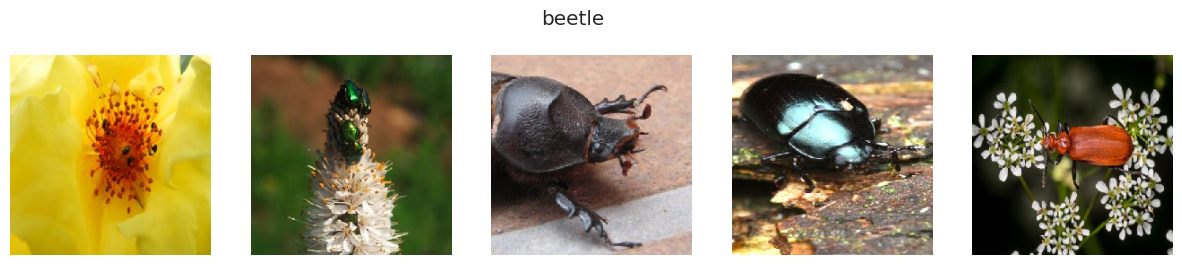

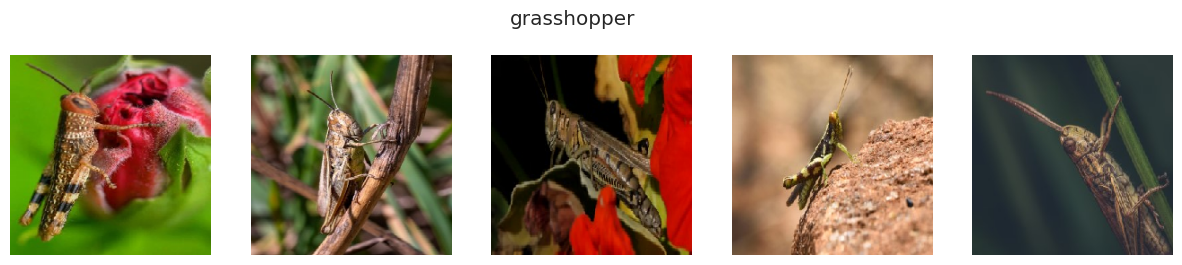

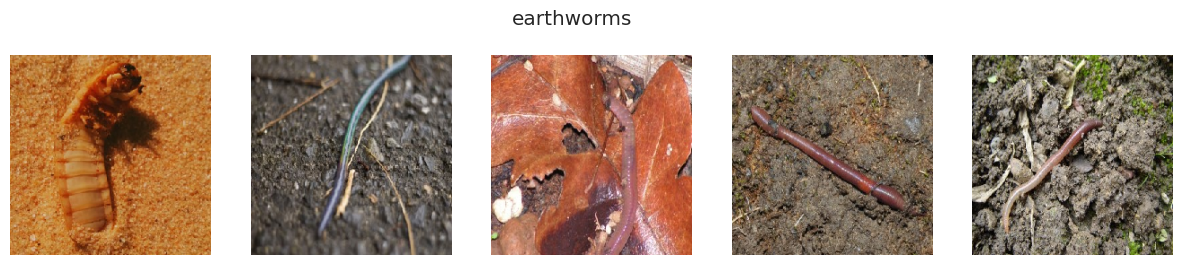

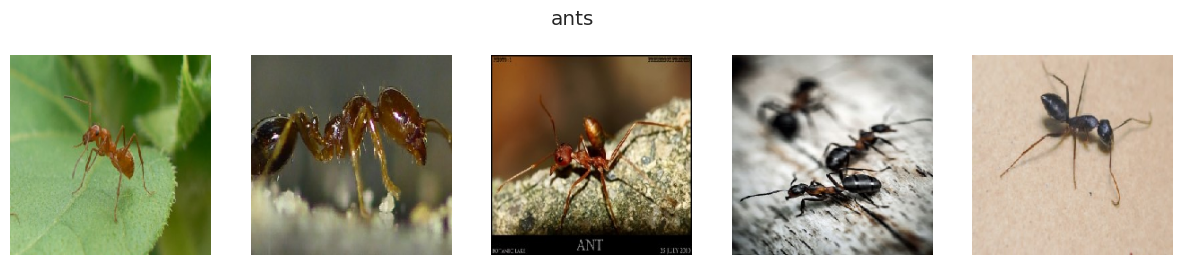

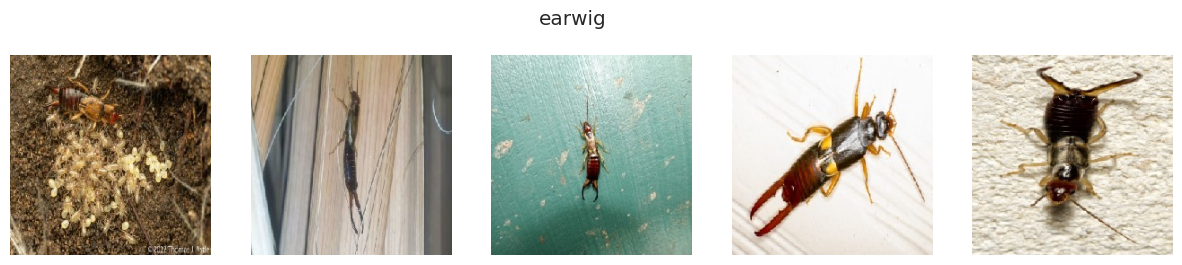

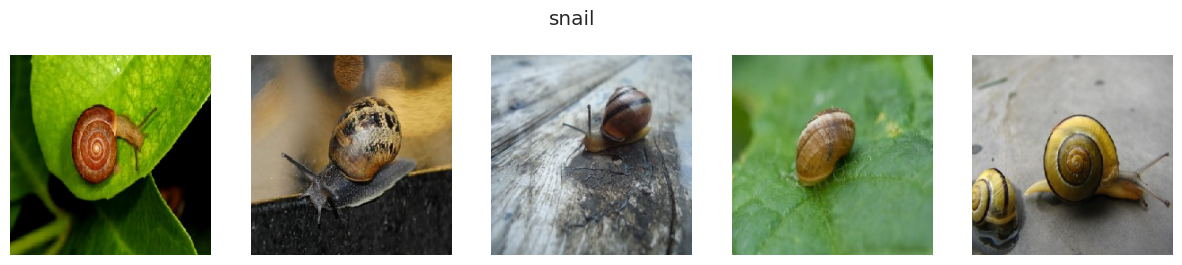

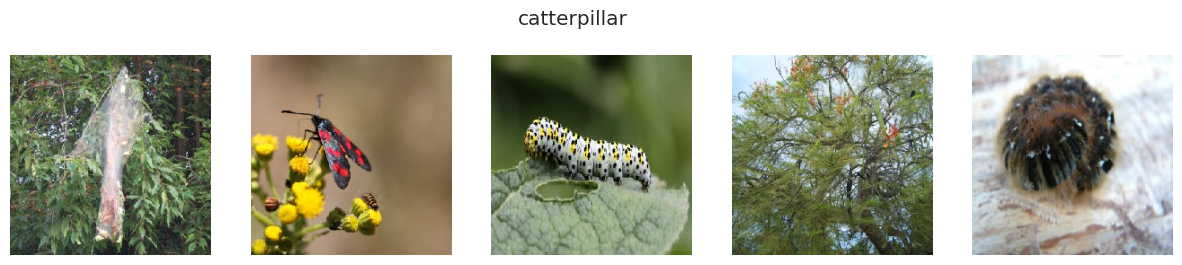

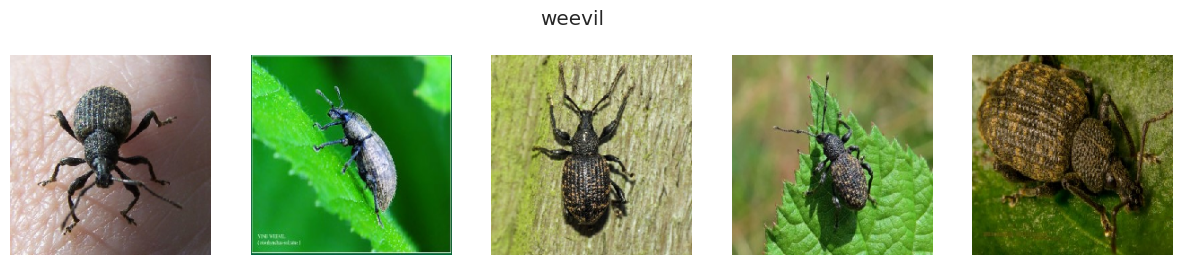

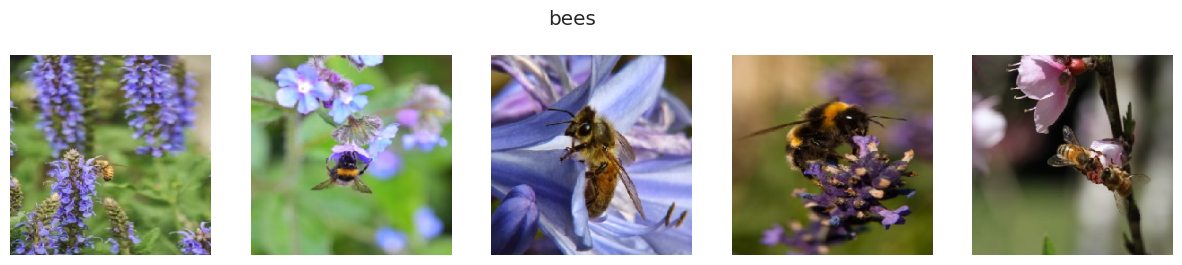

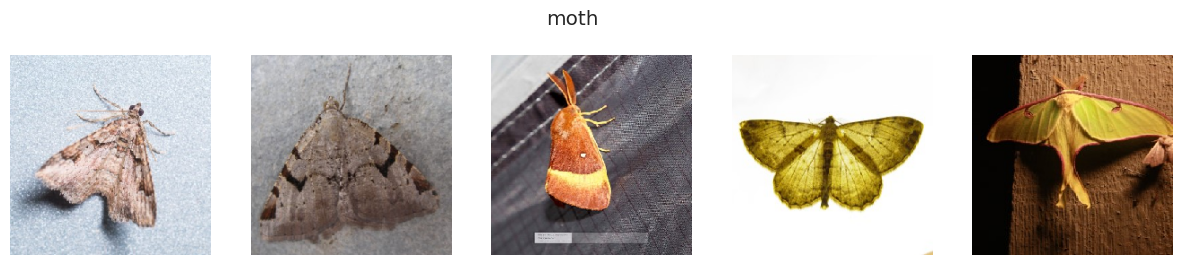

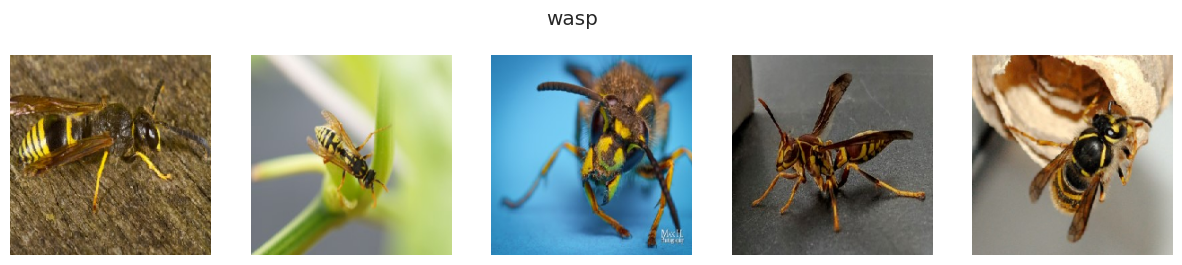

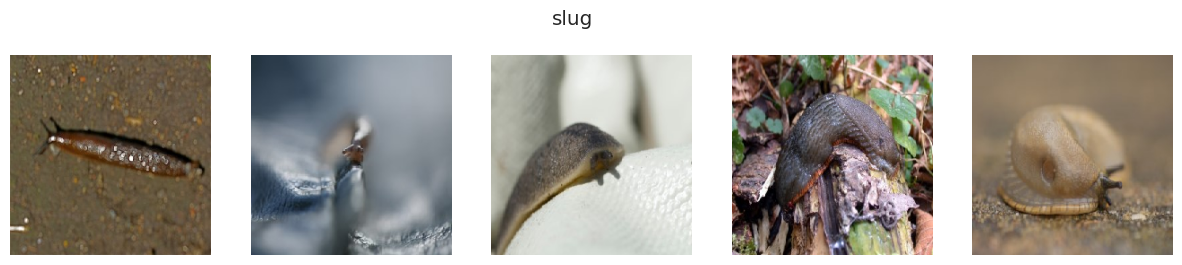

In [6]:
from tensorflow.keras.preprocessing.image import load_img
# Step 2: Print 5 Images from Each Pest Subfolder

# Loop through each pest subfolder
for folder_name in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder_name)

    # Check if the current item is a directory (pest subfolder)
    if os.path.isdir(folder_path):
        # Get a list of all images in the current pest subfolder
        images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Randomly select 5 images from the list
        selected_images = random.sample(images, 5)

        # Print the selected images in multiple columns
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        fig.suptitle(folder_name)

        for i, image_name in enumerate(selected_images):
            image_path = os.path.join(folder_path, image_name)
            image = load_img(image_path, target_size=(224, 224))

            axes[i].imshow(image)
            axes[i].axis('off')

        plt.show()

<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;"> Create a dataframe of the pests with the image path and the labels

In [7]:
# Step 2: Create DataFrame and Store Data

# Initialize lists to store image paths and corresponding labels
image_paths = []
labels = []

# Loop through each pest subfolder
for folder_name in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder_name)

    # Check if the current item is a directory (pest subfolder)
    if os.path.isdir(folder_path):
        # Get a list of all images in the current pest subfolder
        images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for image_name in images:
            image_path = os.path.join(folder_path, image_name)
            image_paths.append(image_path)
            labels.append(folder_name)

# Create a DataFrame from the collected data
data = {
    'image_path': image_paths,
    'label': labels
}
df = pd.DataFrame(data)

# Display the DataFrame
print(df)

                                             image_path   label
0     /kaggle/input/agricultural-pests-image-dataset...  beetle
1     /kaggle/input/agricultural-pests-image-dataset...  beetle
2     /kaggle/input/agricultural-pests-image-dataset...  beetle
3     /kaggle/input/agricultural-pests-image-dataset...  beetle
4     /kaggle/input/agricultural-pests-image-dataset...  beetle
...                                                 ...     ...
5489  /kaggle/input/agricultural-pests-image-dataset...    slug
5490  /kaggle/input/agricultural-pests-image-dataset...    slug
5491  /kaggle/input/agricultural-pests-image-dataset...    slug
5492  /kaggle/input/agricultural-pests-image-dataset...    slug
5493  /kaggle/input/agricultural-pests-image-dataset...    slug

[5494 rows x 2 columns]


<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;">Let us plot the distribution characteristics of the pests

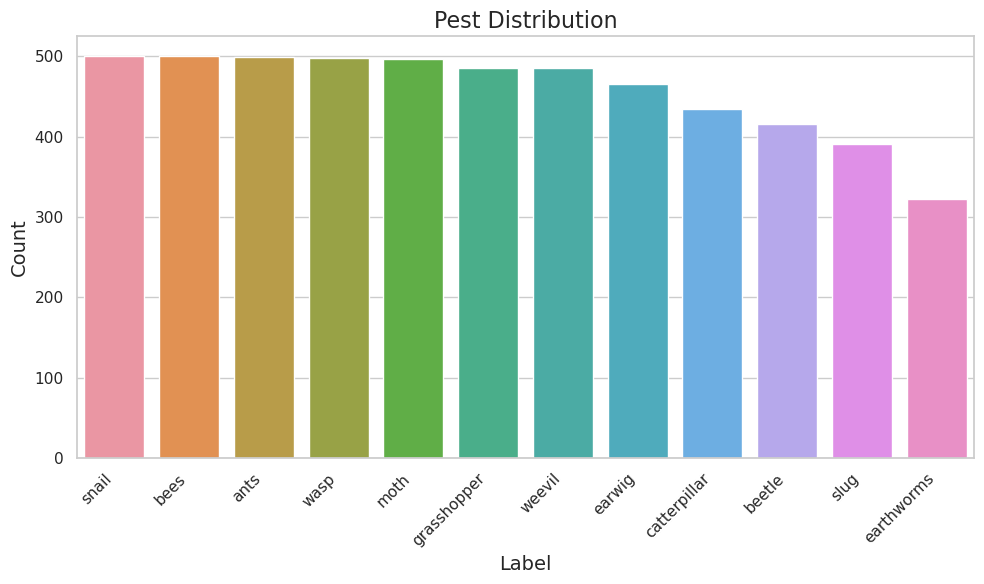

In [8]:
import seaborn as sns
# Plot the label distribution as a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')  # Use a white grid background

# Generate the bar plot
sns.barplot(x=df['label'].value_counts().index, y=df['label'].value_counts().values)

# Customize the plot
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Pest Distribution', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.tight_layout()

# Show the plot
plt.show()

#### It can be seen that last 4 pests have less images than others. The imbalance is not as dominant so we will leave it as it is.

# Train Test Splitting and Data Generator

In [9]:
# Separate in train and test data
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [10]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input
)

In [11]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3516 validated image filenames belonging to 12 classes.
Found 879 validated image filenames belonging to 12 classes.
Found 1099 validated image filenames belonging to 12 classes.


# Data Augmentation

In [12]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.models import Sequential

# Data Augmentation Step
augment = Sequential([
    RandomFlip("horizontal"),            # Random horizontal flipping
    RandomRotation(factor=0.2),          # Random rotation up to 20 degrees
    RandomZoom(height_factor=0.1, width_factor=0.1),  # Random zooming up to 10%
    RandomContrast(factor=0.1),          # Random contrast adjustment up to 10%
])

# Loading of a pretrained ResNet50 Model

In [13]:
from tensorflow.keras.applications import ResNet50
resnet_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='max'
)

resnet_model.trainable = False

# Create checkpoint callback
checkpoint_path = "pests_cats_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

94765736/94765736 [==============================] - 0s 0us/step


In [14]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_loss",  # watch the validation loss metric
                               patience=5,         # stop training if no improvement for 5 epochs
                               restore_best_weights=True)  # restore best weights based on validation loss

# Add additional layers for the custom head of the model
inputs = resnet_model.input
x = augment(inputs)
x = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')(inputs)
x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
x = resnet_model(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
outputs = Dense(12, activation='softmax')(x)

# Training the Model

In [15]:
# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        checkpoint_callback
    ]
)

Epoch 1/100
110/110 [==============================] - 51s 314ms/step - loss: 4.4406 - accuracy: 0.1013 - val_loss: 2.4397 - val_accuracy: 0.1559
Epoch 2/100
110/110 [==============================] - 17s 149ms/step - loss: 2.4861 - accuracy: 0.1325 - val_loss: 2.3805 - val_accuracy: 0.2207
Epoch 3/100
110/110 [==============================] - 16s 149ms/step - loss: 2.4401 - accuracy: 0.1496 - val_loss: 2.3096 - val_accuracy: 0.2491
Epoch 4/100
110/110 [==============================] - 17s 149ms/step - loss: 2.3685 - accuracy: 0.1883 - val_loss: 2.0670 - val_accuracy: 0.3584
Epoch 5/100
110/110 [==============================] - 16s 149ms/step - loss: 2.1939 - accuracy: 0.2645 - val_loss: 1.8548 - val_accuracy: 0.4300
Epoch 6/100
110/110 [==============================] - 17s 151ms/step - loss: 2.0606 - accuracy: 0.3225 - val_loss: 1.6798 - val_accuracy: 0.4801
Epoch 7/100
110/110 [==============================] - 16s 148ms/step - loss: 1.9430 - accuracy: 0.3621 - val_loss: 1.5632 -

<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;"> We can see the training has stopped early because there is no significant increase in the accuracy and it is wastefull to go for more epochs

In [16]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, steps=len(test_images))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

35/35 [==============================] - 9s 264ms/step - loss: 0.6603 - accuracy: 0.8098
Test Loss: 0.6602683067321777
Test Accuracy: 0.8098270893096924


<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;"> We have got an accuracy of 83 % which is not too bad. 

# Model Evaluation

## Visualize the accuracy and loss plots

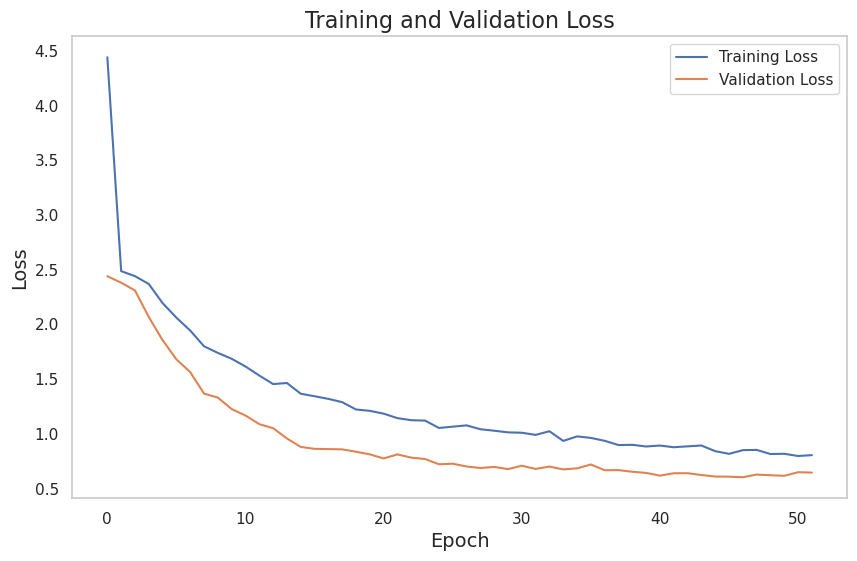

In [17]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.legend()
plt.grid()
plt.show()

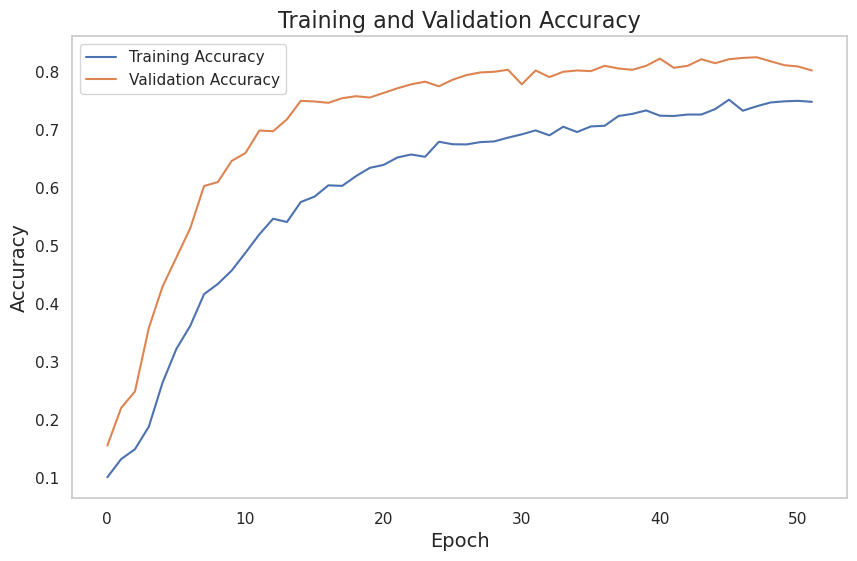

In [18]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.legend()
plt.grid()
plt.show()

<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;"> Here it can be seen that the model is performing better on validation data which indicates the model is not overfitting
    

# Model Predictions

In [19]:
class_names = ['beetle', 'grasshopper', 'earthworms', 'ants', 'earwig', 'snail',
       'catterpillar', 'weevil', 'bees', 'moth', 'wasp', 'slug']  # Replace with your actual class names

# Make predictions on the test data
predictions = model.predict(test_images)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the test data generator
true_labels = test_images.classes

# Calculate the accuracy of the model on the test data
accuracy = np.mean(predicted_labels == true_labels)
print("Test Accuracy:", accuracy)

# Print some sample predictions along with true labels
num_samples = 10
print("Sample Predictions:")
for i in range(num_samples):
    print("True Label:", class_names[true_labels[i]], "| Predicted Label:", class_names[predicted_labels[i]])

35/35 [==============================] - 5s 104ms/step
Test Accuracy: 0.8098271155595996
Sample Predictions:
True Label: snail | Predicted Label: slug
True Label: catterpillar | Predicted Label: catterpillar
True Label: snail | Predicted Label: snail
True Label: earwig | Predicted Label: earwig
True Label: wasp | Predicted Label: wasp
True Label: grasshopper | Predicted Label: grasshopper
True Label: catterpillar | Predicted Label: catterpillar
True Label: wasp | Predicted Label: wasp
True Label: weevil | Predicted Label: weevil
True Label: earwig | Predicted Label: ants


### The predictions are very good

# Classification report and Confusion Matrix

1/1 [==============================] - 2s 2s/step


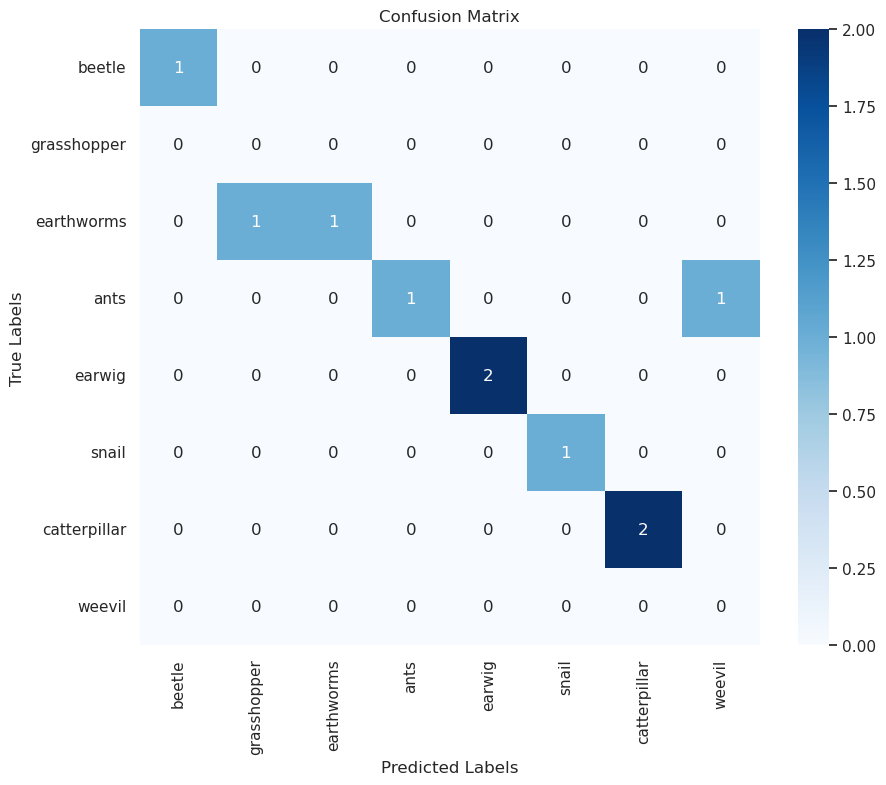

Classification Report:
              precision    recall  f1-score   support

      beetle       1.00      1.00      1.00         1
 grasshopper       0.00      0.00      0.00         0
  earthworms       1.00      0.50      0.67         2
        ants       1.00      0.50      0.67         2
      earwig       1.00      1.00      1.00         2
       snail       1.00      1.00      1.00         1
catterpillar       1.00      1.00      1.00         2
      weevil       0.00      0.00      0.00         0

    accuracy                           0.80        10
   macro avg       0.75      0.62      0.67        10
weighted avg       1.00      0.80      0.87        10



In [20]:
from sklearn.metrics import classification_report, confusion_matrix
class_names = ['beetle', 'grasshopper', 'earthworms', 'ants', 'earwig', 'snail','catterpillar', 'weevil']
# Get a batch of test data (you can adjust the batch size as needed)
batch_size = 10
test_data = next(iter(test_images))
images = test_data[0][:batch_size]  # Get the images from the test data batch
true_labels = test_data[1][:batch_size]  # Get the true labels from the test data batch

# Make predictions on the test data
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Convert the one-hot encoded true_labels to class indices
true_labels = np.argmax(true_labels, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Generate the classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))


# Loading of a pretrained InceptionV3 Model

In [21]:
from tensorflow.keras.applications import InceptionV3

# Load the pretained model
pretrained_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = True

# Create checkpoint callback
checkpoint_path = "pests_cats_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_loss",  # watch the validation loss metric
                               patience=5,         # stop training if no improvement for 5 epochs
                               restore_best_weights=True)  # restore best weights based on validation loss

# Add additional layers for the custom head of the model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = augment(inputs)
x = tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal')(x)
x = tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)(x)
x = pretrained_model(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
outputs = Dense(12, activation='softmax')(x)

87910968/87910968 [==============================] - 0s 0us/step


# IneptionV3 Model Training


In [22]:

# Create the final model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        checkpoint_callback
    ]
)


Epoch 1/100
110/110 [==============================] - 89s 366ms/step - loss: 2.3806 - accuracy: 0.2389 - val_loss: 1.2793 - val_accuracy: 0.6382
Epoch 2/100
110/110 [==============================] - 32s 286ms/step - loss: 1.3991 - accuracy: 0.5475 - val_loss: 0.7414 - val_accuracy: 0.7964
Epoch 3/100
110/110 [==============================] - 32s 289ms/step - loss: 1.0105 - accuracy: 0.6988 - val_loss: 0.6178 - val_accuracy: 0.8373
Epoch 4/100
110/110 [==============================] - 32s 289ms/step - loss: 0.8227 - accuracy: 0.7571 - val_loss: 0.5486 - val_accuracy: 0.8532
Epoch 5/100
110/110 [==============================] - 30s 273ms/step - loss: 0.6898 - accuracy: 0.8066 - val_loss: 0.5686 - val_accuracy: 0.8532
Epoch 6/100
110/110 [==============================] - 32s 291ms/step - loss: 0.6073 - accuracy: 0.8282 - val_loss: 0.5491 - val_accuracy: 0.8635
Epoch 7/100
110/110 [==============================] - 34s 310ms/step - loss: 0.5381 - accuracy: 0.8473 - val_loss: 0.5233 -

In [23]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, steps=len(test_images))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

35/35 [==============================] - 5s 140ms/step - loss: 0.4460 - accuracy: 0.8799
Test Loss: 0.44596803188323975
Test Accuracy: 0.8798907995223999


<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;"> The accuracy has been increased from 82 to 86 % with respect to InceptionV3 model

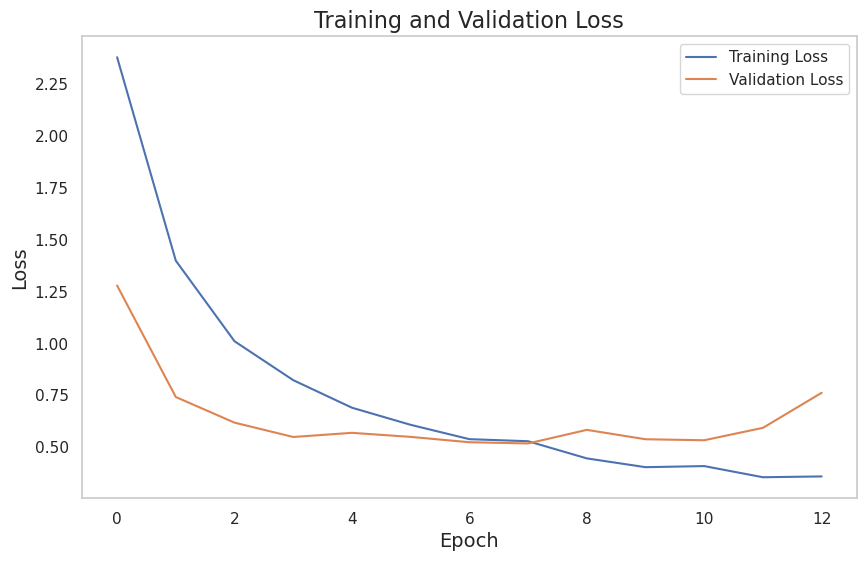

In [24]:
# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Validation Loss', fontsize=16)
plt.legend()
plt.grid()
plt.show()

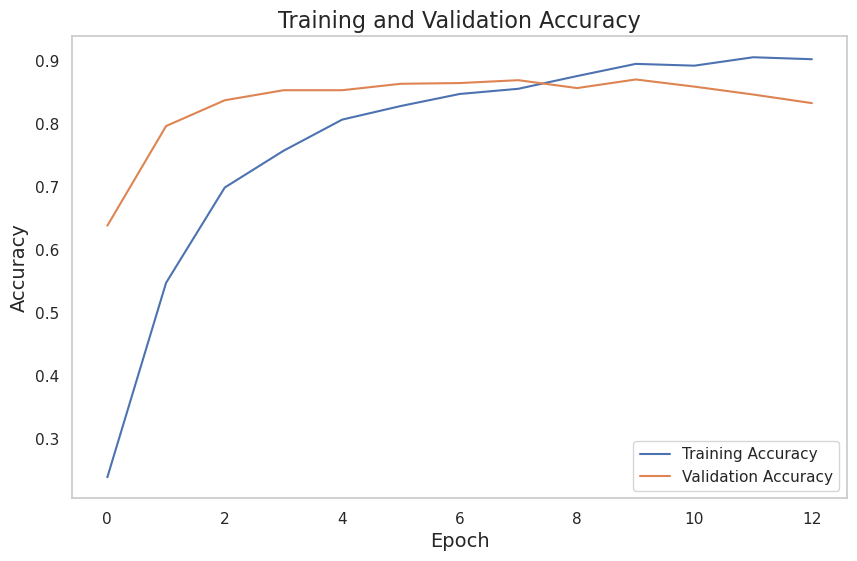

In [25]:
# Plot training and validation accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.legend()
plt.grid()
plt.show()

<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;"> After 6 epochs, the loss is increasing and the accuracy of the validation set is decreasing. That is where earlystopping comes into play. 

# InceptionV3 model prediction

In [26]:
class_names = ['beetle', 'grasshopper', 'earthworms', 'ants', 'earwig', 'snail',
       'catterpillar', 'weevil', 'bees', 'moth', 'wasp', 'slug']  # Replace with your actual class names

# Make predictions on the test data
predictions = model.predict(test_images)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the true labels from the test data generator
true_labels = test_images.classes

# Calculate the accuracy of the model on the test data
accuracy = np.mean(predicted_labels == true_labels)
print("Test Accuracy:", accuracy)

# Print some sample predictions along with true labels
num_samples = 10
print("Sample Predictions:")
for i in range(num_samples):
    print("True Label:", class_names[true_labels[i]], "| Predicted Label:", class_names[predicted_labels[i]])

35/35 [==============================] - 5s 93ms/step
Test Accuracy: 0.8798908098271155
Sample Predictions:
True Label: snail | Predicted Label: snail
True Label: catterpillar | Predicted Label: catterpillar
True Label: snail | Predicted Label: snail
True Label: earwig | Predicted Label: earwig
True Label: wasp | Predicted Label: wasp
True Label: grasshopper | Predicted Label: grasshopper
True Label: catterpillar | Predicted Label: catterpillar
True Label: wasp | Predicted Label: wasp
True Label: weevil | Predicted Label: weevil
True Label: earwig | Predicted Label: earwig


# Conclusion
<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;">In this Kaggle notebook, we delved into the exciting domain of agricultural pest classification using deep learning techniques. Our main goal was to assist farmers in effectively identifying and managing common agricultural pests, which can significantly impact crop yield and quality.

<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;">Throughout the project, we employed two powerful pre-trained deep learning models, ResNet and InceptionV3, to tackle the pest classification task. After thorough data preprocessing and augmentation, we fine-tuned both models using transfer learning techniques, leveraging their pre-trained knowledge for our specific agricultural pest classification.

<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;">Upon evaluation, we observed that the InceptionV3 model outperformed ResNet, achieving an impressive accuracy of 86%. This notable improvement from 82% demonstrated the superiority of the InceptionV3 architecture for our classification task. By automating the pest identification process, our deep learning models offer a reliable and efficient tool for farmers to identify and manage agricultural pests. This technology can significantly contribute to sustainable agriculture practices, ensuring timely pest detection and precise management.

<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;">In conclusion, this project showcases the potential of deep learning in addressing real-world challenges faced by the agricultural sector. With continued research and innovation, we can harness the power of AI to enhance precision agriculture and contribute to global food security.

<p style="font-family: 'Arial', sans-serif; font-size: 18px; color: #333333;text-align: justify;">Let's continue exploring the realms of artificial intelligence and its applications in various fields, driving positive change and advancements for a better tomorrow. Happy learning and happy farming!